In [1]:
# derived from:
# https://github.com/higgsfield/RL-Adventure-2/blob/master/7.soft%20actor-critic.ipynb
# found link at https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665
# altered to run biped

import math
import random
from collections import deque

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

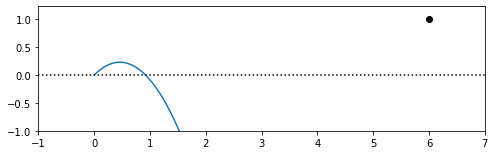

In [4]:
def plotTrajectory(x_vel, y_vel, acc, t_final, x_target, y_target, ax = None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 8))

    ts = np.linspace(0,t_final,100)
    xs = ts*x_vel
    ys = y_vel*ts + acc*ts**2

    ax.set_aspect("equal", "box")
    ax.set_xlim([-1, x_target+1])
    ax.set_ylim([-1, np.max(ys)+1])


    ax.plot(xs,ys)
    ax.plot([-1, np.max(xs)+1],[0,0],":k")

    ax.scatter([x_target], [y_target], c="black")

plotTrajectory(x_vel=3, y_vel=3, acc=-9.8, t_final=2, x_target=6, y_target=1)

In [5]:
def plotTrajectory_torch(vel, acc, t_final, target, ax=None):
    x_vel, y_vel = vel.detach().numpy()
    # acc  = acc.detach().numpy()
    t_final = t_final.detach().numpy()
    x_target, y_target = target.detach().numpy()
    plotTrajectory(x_vel, y_vel, acc, t_final, x_target, y_target, ax)

tensor([[0.5767],
        [0.0135]], requires_grad=True) tensor([[27.5612],
        [28.0605]]) tensor([-22378.9727], grad_fn=<AddBackward0>) tensor([5.0208e+08], grad_fn=<PowBackward0>)


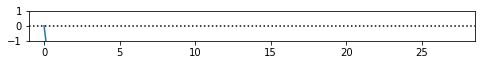

In [109]:
vel_xy_0 = torch.rand(2,1, requires_grad=True)
target = (torch.rand(2,1)+2)*10
acc = -9.8
t_final = target[0]/vel_xy_0[0]
# x_final = vel_xy_0[0] * torch.sqrt(torch.pow(vel_xy_0[1],2)/-acc)
y_final = vel_xy_0[1]*t_final + acc*(t_final**2)
targetMissLoss = torch.pow(y_final-target[1], 2)
# torch.sqrt(torch.pow(vel_xy_0[0],2)/-acc)
print(vel_xy_0, target, y_final, targetMissLoss)

plotTrajectory_torch(vel=vel_xy_0, acc=acc, t_final=t_final, target=target)

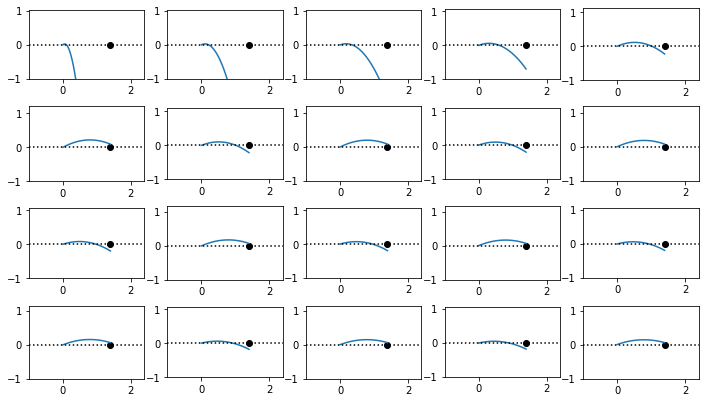

In [115]:
vel_xy_0 = torch.ones(2,1, requires_grad=True)
LR=1

acc = -9.8 
target = (torch.rand(2,1)+1)
target[1] = 0

f, axs = plt.subplots(4,5,figsize=(12,7))
axs = axs.ravel()

for i in range(20):
    t_final = target[0]/vel_xy_0[0]  
    y_final = vel_xy_0[1]*t_final + acc*(t_final**2)
    targetMissLoss = -(y_final-target[1])**2

    targetMissLoss.backward(retain_graph=True)
    
    grad = vel_xy_0.grad/torch.norm(vel_xy_0.grad)

    # print("vel_xy_0",vel_xy_0)
    # print("target", target)
    # print("y_final", y_final)
    # print("targetMissLoss", targetMissLoss)
    # print("grad", grad)

    # plt.gcf().show()
    plotTrajectory_torch(vel=vel_xy_0, acc=acc, t_final=t_final, target=target, ax= axs[i])
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    vel_xy_0.data =  vel_xy_0.data + LR*grad.data
    vel_xy_0.grad.data.zero_()

tensor([-0.0579], grad_fn=<NegBackward>)

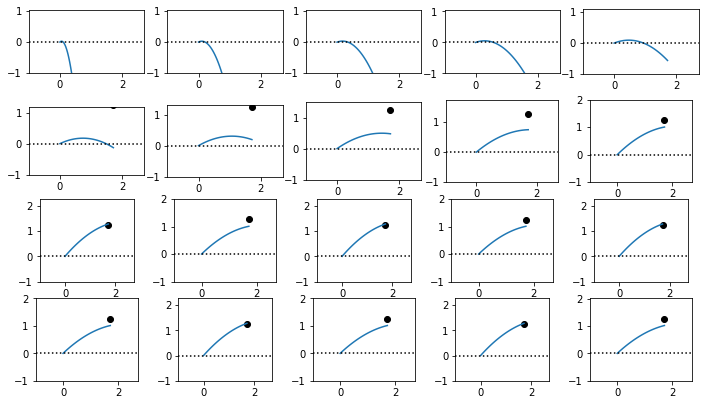

In [122]:
vel_xy_0 = torch.ones(2,1, requires_grad=True)
LR=1

acc = -9.8 
target = torch.rand(2,1)+1
target[1] 

f, axs = plt.subplots(4,5,figsize=(12,7))
axs = axs.ravel()

for i in range(20):
    t_final = target[0]/vel_xy_0[0]  
    y_final = vel_xy_0[1]*t_final + acc*(t_final**2)
    targetMissLoss = -(y_final-target[1])**2

    targetMissLoss.backward(retain_graph=True)
    
    grad = vel_xy_0.grad/torch.norm(vel_xy_0.grad)

    # print("vel_xy_0",vel_xy_0)
    # print("target", target)
    # print("y_final", y_final)
    # print("targetMissLoss", targetMissLoss)
    # print("grad", grad)

    # plt.gcf().show()
    plotTrajectory_torch(vel=vel_xy_0, acc=acc, t_final=t_final, target=target, ax= axs[i])
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    vel_xy_0.data =  vel_xy_0.data + LR*grad.data
    vel_xy_0.grad.data.zero_()
targetMissLoss

In [120]:

vel_x = torch.ones(2,1, requires_grad=True)
# torch.cat([vel_x,vel_x],0)
# vel_x

tensor([[1.],
        [1.]], requires_grad=True)

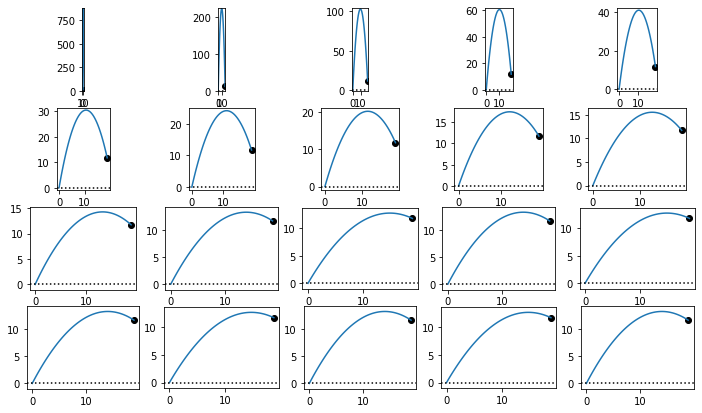

In [136]:
# most energy efficient trajectory constrained to go through a specific point
vel_x = torch.ones(1, requires_grad=True)
LR=1

acc = -9.8 
target = (torch.rand(2,1)+1)*10
# target[1]=0

f, axs = plt.subplots(4,5,figsize=(12,7))
axs = axs.ravel()

for i in range(20):
    t_final = target[0]/vel_x[0]
    vel_y0 = target[1]/t_final - acc*t_final
    vel_xy_0 = torch.stack([vel_x,vel_y0],0)
    keLoss = -torch.sum(vel_xy_0**2)

    keLoss.backward(retain_graph=True)
    
    grad = vel_x.grad/torch.norm(vel_x.grad)
    plotTrajectory_torch(vel=vel_xy_0, acc=acc, t_final=t_final, target=target, ax= axs[i])

    vel_x.data =  vel_x.data + LR*grad.data
    vel_x.grad.data.zero_()

True

0.923766016960144
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.5003284215927124


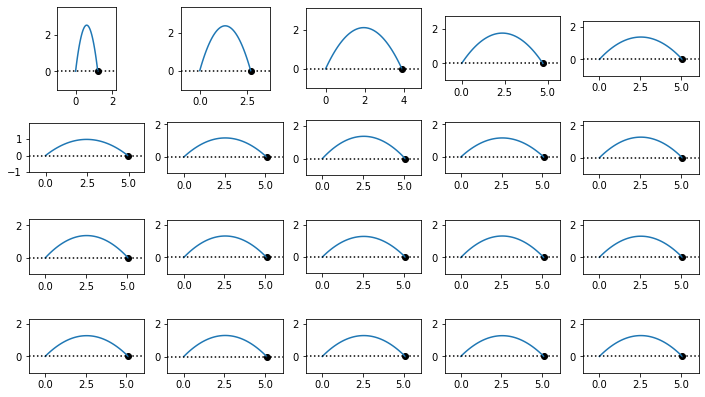

In [26]:
# for fixed KE, the farthes possible shot

angle = torch.rand(1, requires_grad=True)

energy = 100
LR=.1

acc = -9.8 
target = (torch.rand(2,1)+1)*10
target[1]=0

f, axs = plt.subplots(4,5,figsize=(12,7))
axs = axs.ravel()

lastObj = -np.inf

print(angle.item())

for i in range(20):
    vel_x = torch.cos(angle*np.pi/2)*np.sqrt(energy)
    vel_y0 = torch.sin(angle*np.pi/2)*np.sqrt(energy)
    t_final = vel_y0/-acc
    distance = vel_x*t_final
    vel_xy_0 = torch.stack([vel_x,vel_y0],0)
    target = torch.stack([distance,torch.zeros(1)],0)

    if distance.item()<lastObj:
        LR = LR/2
        print(LR)
    lastObj = distance.item()

    distance.backward(retain_graph=True)
    
    grad = angle.grad/torch.norm(angle.grad)
    # print(grad)
    plotTrajectory_torch(vel=vel_xy_0, acc=acc, t_final=t_final, target=target, ax= axs[i])

    angle.data =  angle.data + LR*grad.data
    angle.grad.data.zero_()
    
print(angle.item())

In [239]:
def plotHeadingSteps(pos, target, ax = None, radius = None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 8))
    R = radius if radius is not None else np.linalg.norm(target)+1

    ax.set_aspect("equal", "box")
    ax.set_xlim([-R, R])
    ax.set_ylim([-R, R])

    ax.plot(pos[0,:],pos[1,:])
    ax.scatter([0,target[0]], [0,target[1]], c="black")

In [160]:
23 % 4

3

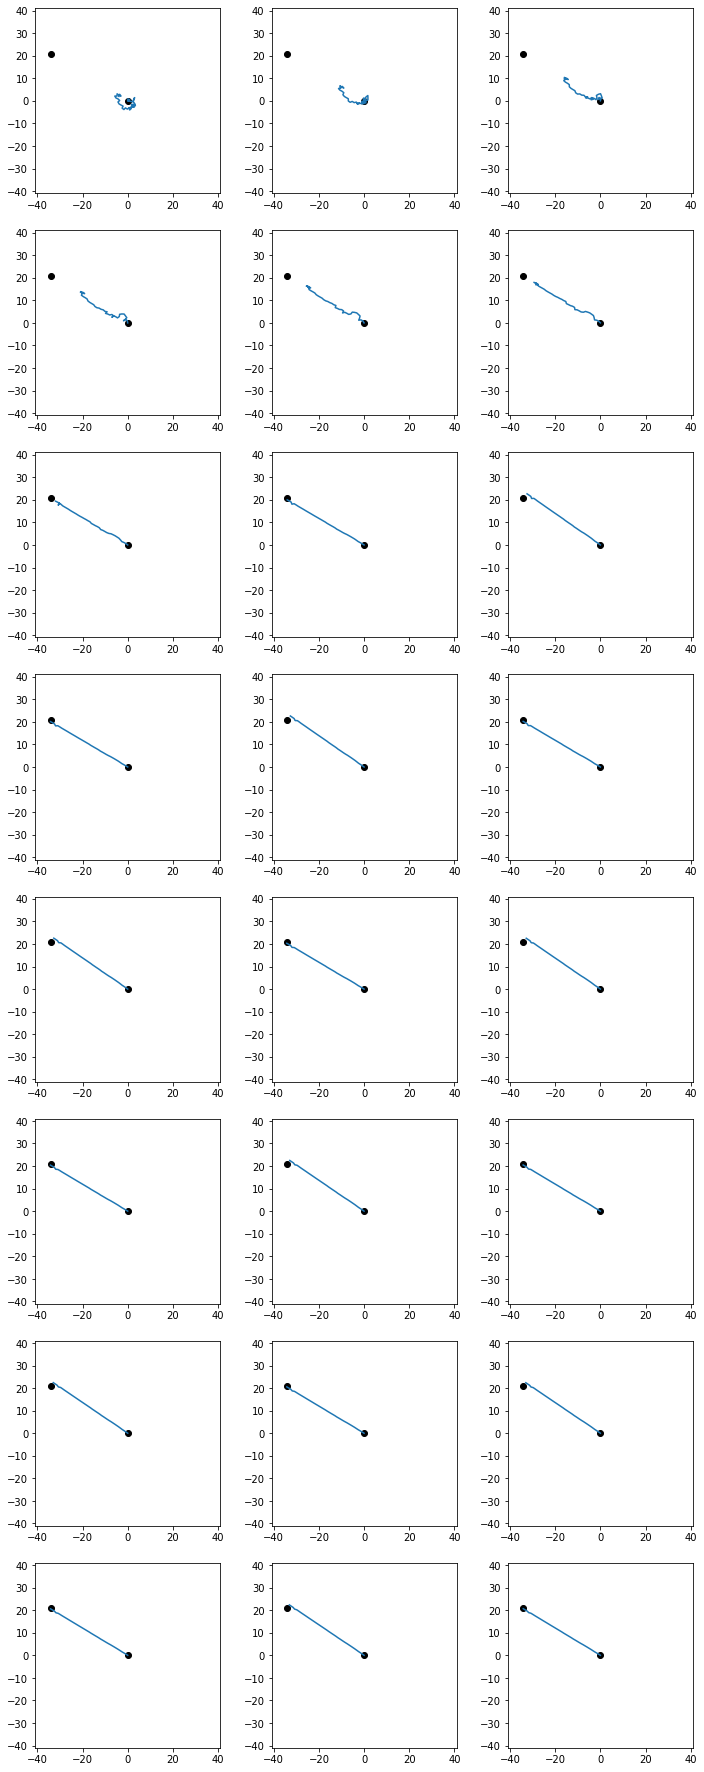

In [223]:
# trying to get to a target, taking steps of length 1 and choosing direction
T=40
heading_inputs = torch.rand(1,T, requires_grad=True)
targetDirection = torch.rand(1)*2*np.pi
target = torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*T

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

LR = .1

lastObj=np.inf

M = 3
for i in range(r*c*M):
    headings = heading_inputs*2*np.pi
    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps2 = torch.cat([torch.zeros(2,1),steps],1)

    pos = torch.cumsum(steps2,1)

    distance = -torch.sum((pos[:,-1] - target)**2)

    LR = LR*.99
    lastObj = distance.item()

    distance.backward(retain_graph=True)
    
    grad = heading_inputs.grad/torch.norm(heading_inputs.grad)

    if i%M == 0:
        plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M])
    
    heading_inputs.data =  heading_inputs.data + LR*grad.data
    heading_inputs.grad.data.zero_()

target tensor([-19.7274,  -3.2908])


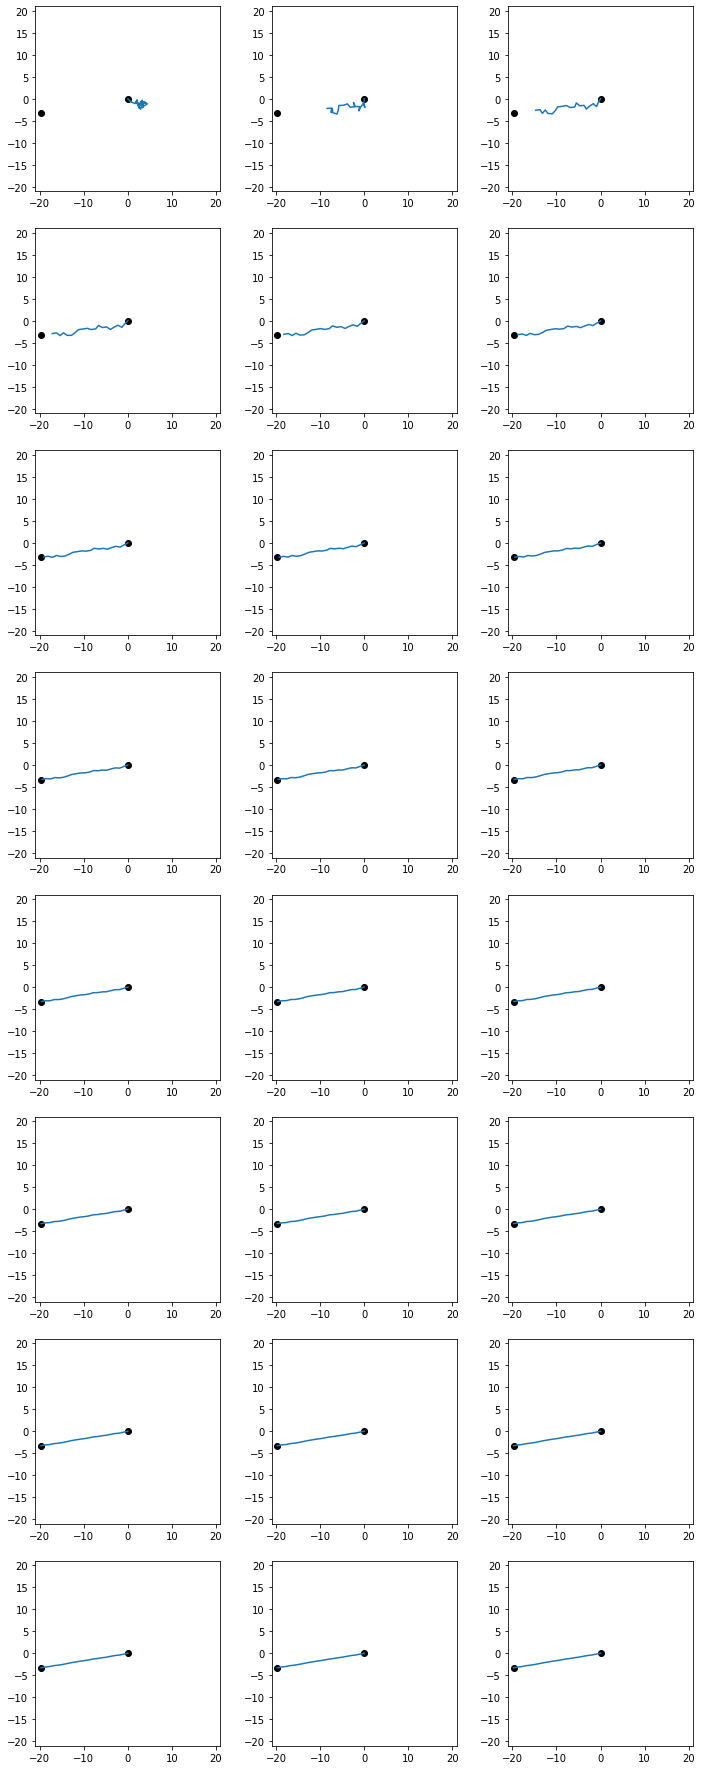

In [224]:
# trying to get to a target, taking steps of length 1 and choosing direction
# as above, but using built in optimizer
T=20
heading_inputs = torch.rand(1,T, requires_grad=True)
targetDirection = torch.rand(1)*2*np.pi
target = torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*T
print("target",target)

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

optAdam  = torch.optim.Adam([heading_inputs], lr=3e-4)


M = 500
for i in range(r*c*M):
    headings = heading_inputs*2*np.pi
    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps2 = torch.cat([torch.zeros(2,1),steps],1)

    pos = torch.cumsum(steps2,1)

    loss = torch.sum((pos[:,-1] - target)**2)

    optAdam.zero_grad()
    loss.backward()
    optAdam.step()

    if i%M == 0:
        plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M])


target tensor([13.3312,  0.2412])


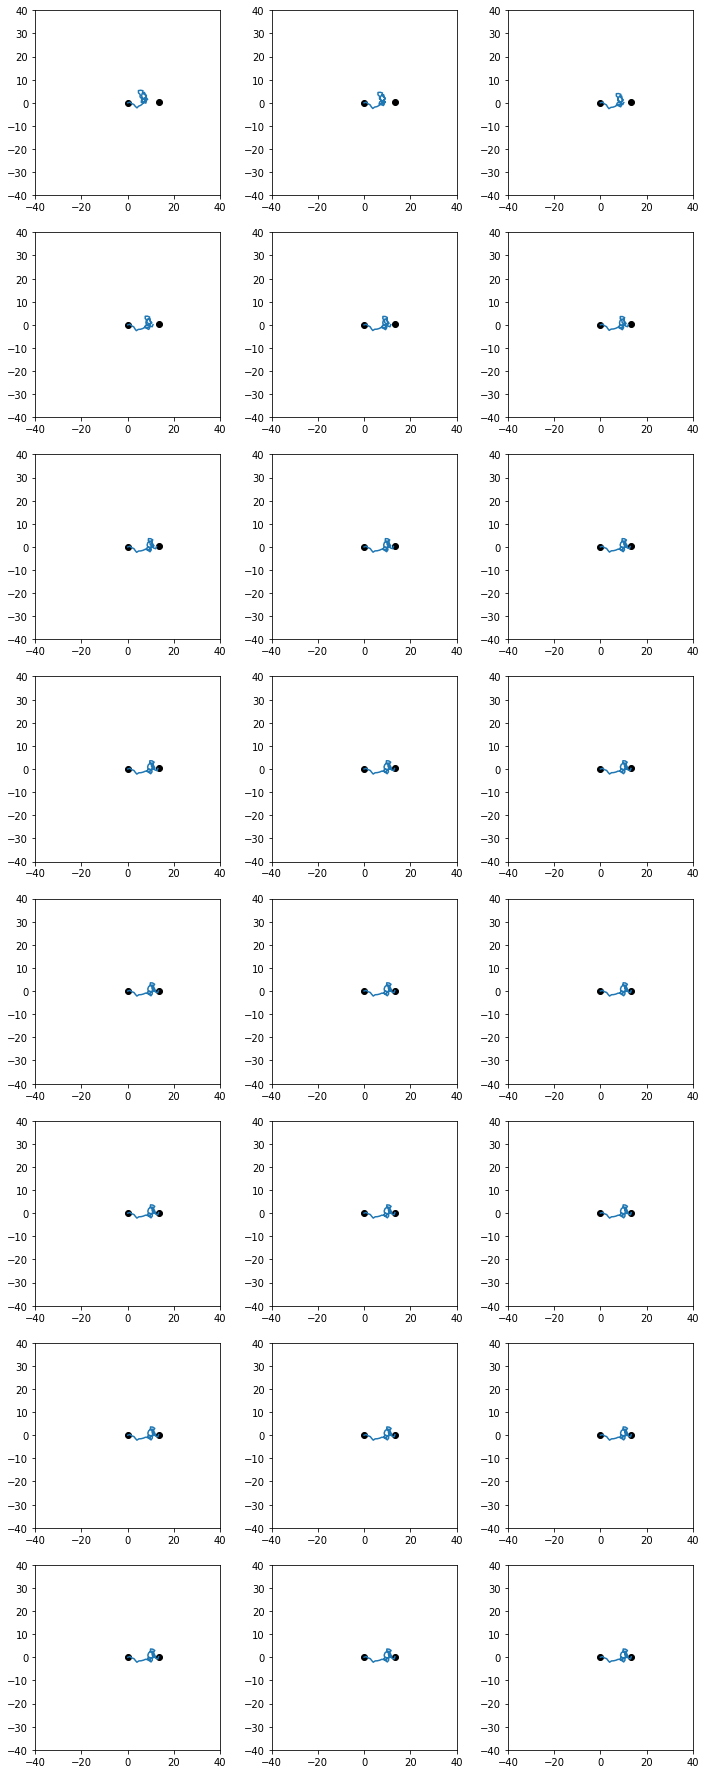

In [245]:
# trying to get to a target by "steering" (choosing an angle change)
# given constant step length 1
# as above, but using built in optimizer
T=40

maxTurn=np.pi/2

steering_inputs = torch.randn(1,T, requires_grad=True)
targetDirection = (torch.rand(1)-.5)*np.pi
target = torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*T/3
print("target",target)

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

optAdam  = torch.optim.Adam([steering_inputs], lr=3e-4)


M = 100
for i in range(r*c*M):
    steering_inputs_clamped = torch.clamp(steering_inputs,-maxTurn,maxTurn)
    headings = torch.cumsum(steering_inputs_clamped,1)

    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps_with_x0 = torch.cat([torch.zeros(2,1),steps],1)

    pos = torch.cumsum(steps_with_x0,1)

    loss = torch.sum((pos[:,-1] - target)**2)

    optAdam.zero_grad()
    loss.backward()
    optAdam.step()

    if i%M == 0:
        # print(steering_inputs)
        plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M], radius=T)


target tensor([ 2.1542, 13.1582])


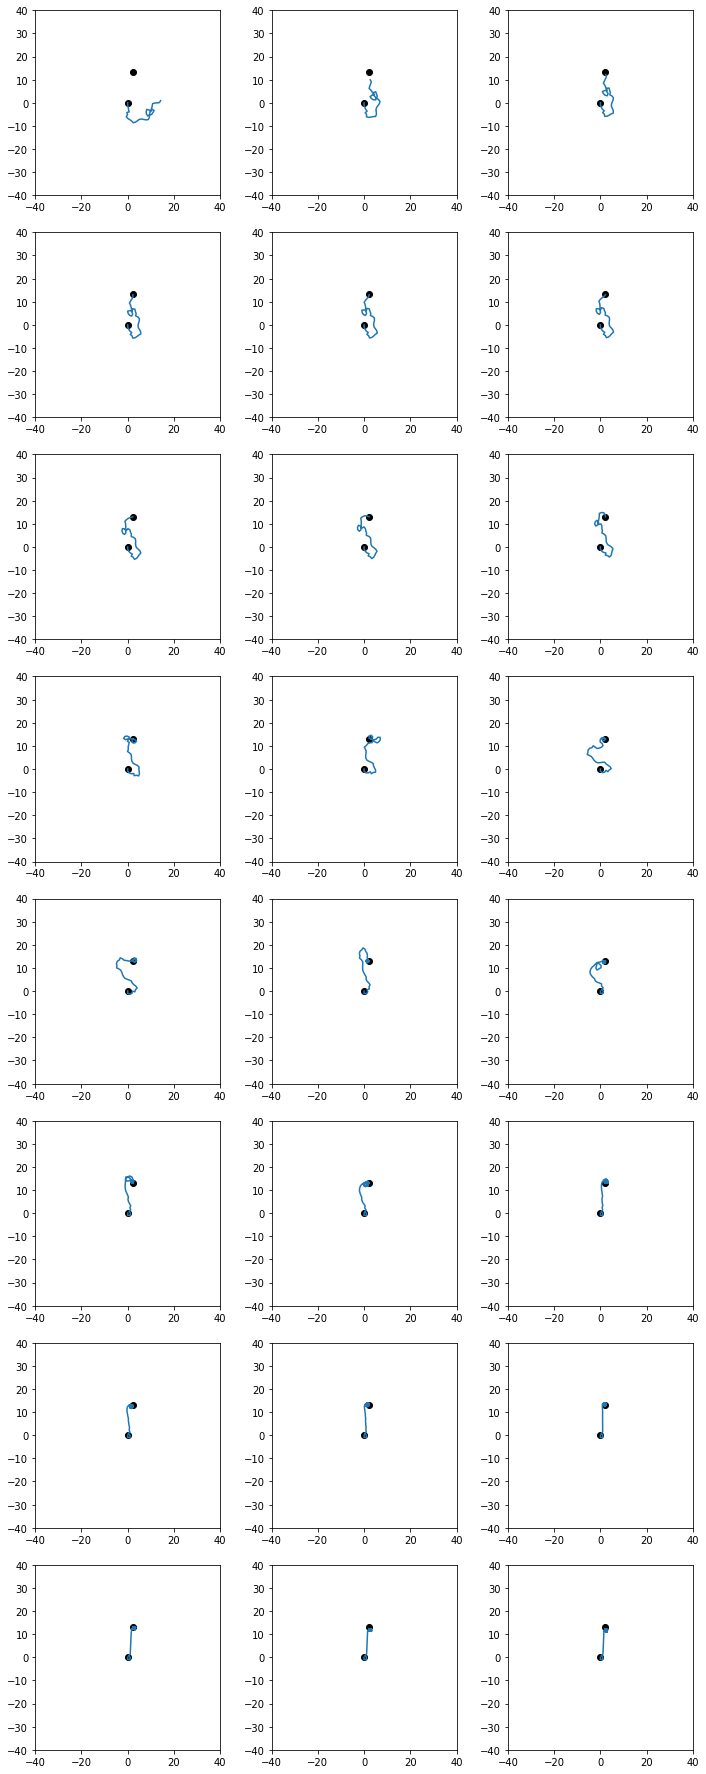

In [247]:
# trying to get to a target by "steering" (choosing an angle change)
# given constant step length 1, and also imposing a smoothness constraint

# Interesting-- just summing the steering_inpust in the loss function
# i like a weird L1 penalty that tries to drive a lof of inputs to zero,
# and tries to balance positive and negative inputs (left and right turns)

T=40

maxTurn=np.pi/2

steering_inputs = torch.randn(1,T, requires_grad=True)
targetDirection = (torch.rand(1)-.5)*np.pi
target = torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*T/3
print("target",target)

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

optAdam  = torch.optim.Adam([steering_inputs], lr=3e-4)


M = 1000
for i in range(r*c*M):
    steering_inputs_clamped = torch.clamp(steering_inputs,-maxTurn,maxTurn)
    headings = torch.cumsum(steering_inputs_clamped,1)

    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps_with_x0 = torch.cat([torch.zeros(2,1),steps],1)

    pos = torch.cumsum(steps_with_x0,1)

    loss = torch.sum((pos[:,-1] - target)**2) + torch.sum(steering_inputs)

    optAdam.zero_grad()
    loss.backward()
    optAdam.step()

    if i%M == 0:
        # print(steering_inputs)
        plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M], radius=T)


target tensor([12.9788,  3.0542])


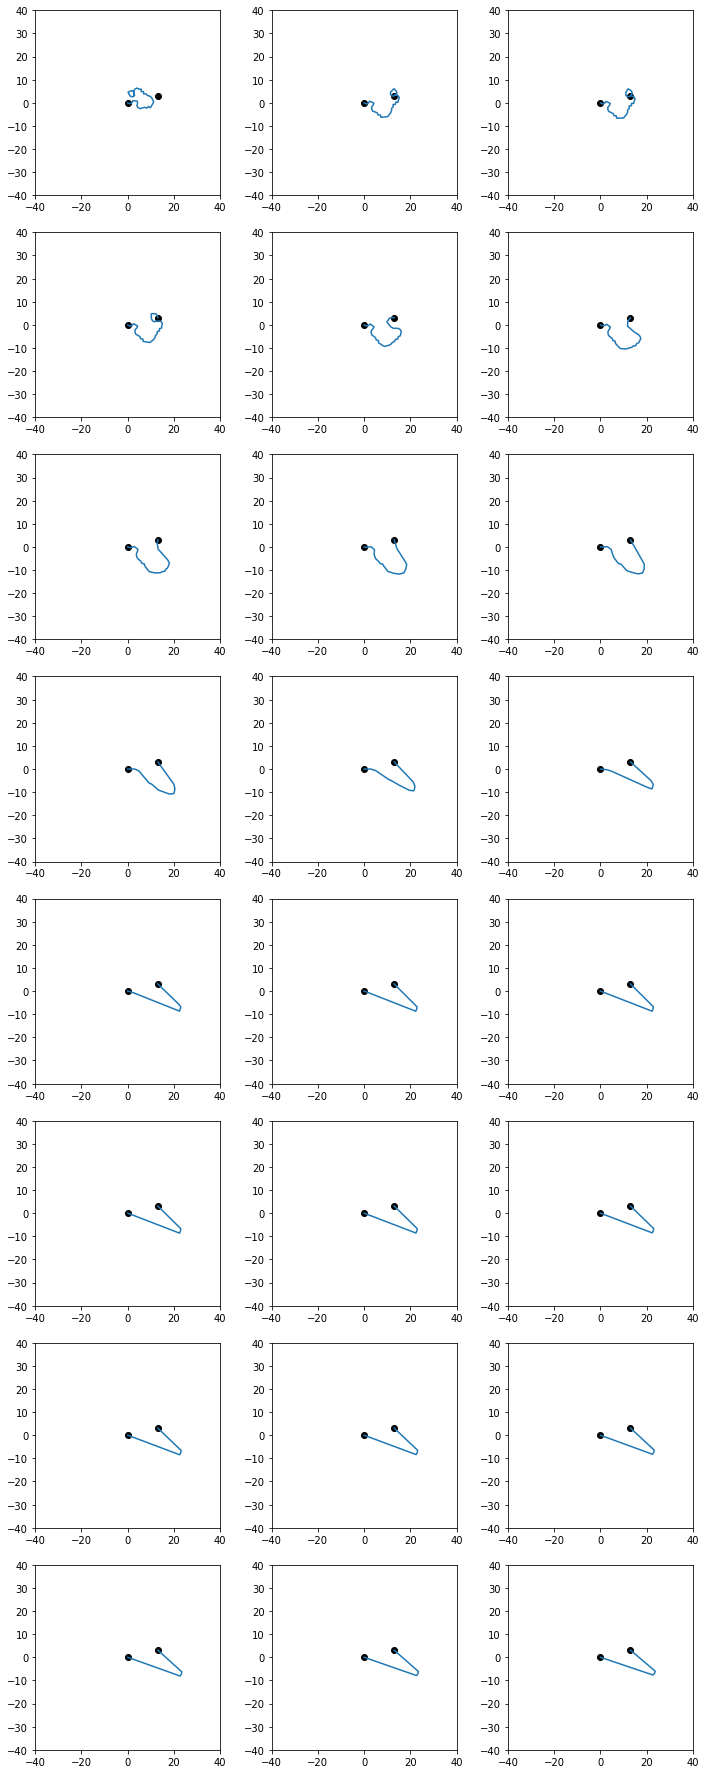

In [248]:
# trying to get to a target by "steering" (choosing an angle change)
# given constant step length 1, and also imposing a smoothness constraint

# proper L1 smoothness penalty here

T=40

maxTurn=np.pi/2

steering_inputs = torch.randn(1,T, requires_grad=True)
targetDirection = (torch.rand(1)-.5)*np.pi
target = torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*T/3
print("target",target)

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

optAdam  = torch.optim.Adam([steering_inputs], lr=3e-4)


M = 1000
for i in range(r*c*M):
    steering_inputs_clamped = torch.clamp(steering_inputs,-maxTurn,maxTurn)
    headings = torch.cumsum(steering_inputs_clamped,1)

    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps_with_x0 = torch.cat([torch.zeros(2,1),steps],1)

    pos = torch.cumsum(steps_with_x0,1)

    loss = torch.sum((pos[:,-1] - target)**2) + torch.sum(torch.abs(steering_inputs))

    optAdam.zero_grad()
    loss.backward()
    optAdam.step()

    if i%M == 0:
        # print(steering_inputs)
        plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M], radius=T)


target tensor([11.8840, -6.0455])


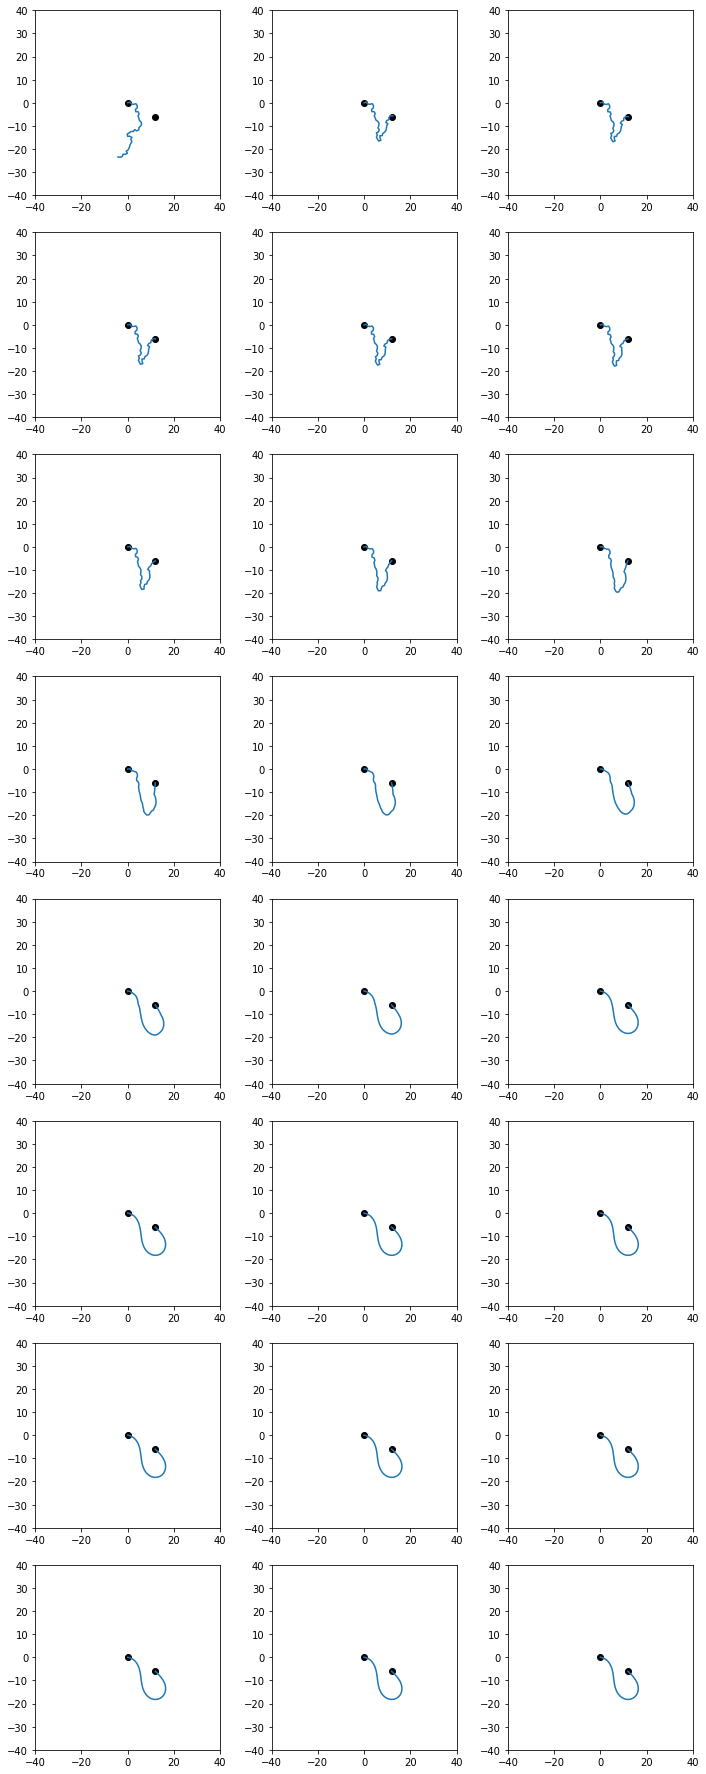

In [250]:
# trying to get to a target by "steering" (choosing an angle change)
# given constant step length 1, and also imposing a smoothness constraint

# L2 smoothness penalty here

T=40

maxTurn=np.pi/2

steering_inputs = torch.randn(1,T, requires_grad=True)
targetDirection = (torch.rand(1)-.5)*np.pi
target = torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*T/3
print("target",target)

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

optAdam  = torch.optim.Adam([steering_inputs], lr=3e-4)


M = 1000
for i in range(r*c*M):
    steering_inputs_clamped = torch.clamp(steering_inputs,-maxTurn,maxTurn)
    headings = torch.cumsum(steering_inputs_clamped,1)

    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps_with_x0 = torch.cat([torch.zeros(2,1),steps],1)

    pos = torch.cumsum(steps_with_x0,1)

    loss = torch.sum((pos[:,-1] - target)**2) + torch.sum(steering_inputs**2)

    optAdam.zero_grad()
    loss.backward()
    optAdam.step()

    if i%M == 0:
        # print(steering_inputs)
        plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M], radius=T)


In [5]:
# print(pos)

def plotHeadingStepsWithBump(pos, target, bumpPos, bumpStd, ax = None, radius = None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 8))
    R = radius if radius is not None else np.linalg.norm(target)+1

    ax.set_aspect("equal", "box")
    ax.set_xlim([-R, R])
    ax.set_ylim([-R, R])

    x = np.arange(-R, R, R/50)
    y = np.arange(-R, R, R/50)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(bumpPos.shape[1]):
        Z += np.exp(-((X - bumpPos[0,i])**2 + (Y - bumpPos[1,i])**2)/bumpStd)

    CS = ax.contour(X, Y, Z)
    ax.plot(pos[0,:],pos[1,:])
    ax.scatter([0,target[0]], [0,target[1]], c="black", s=5)

# plotHeadingStepsWithBump(
#     pos.detach().numpy(),
#     target.detach().numpy(),
#     (torch.randn(2,5)*10).detach().numpy(),
#     T,
#     radius=T
# )

# print(pos.size())
# print(pos.unsqueeze(2).size(), torch.randn(2,5).unsqueeze(1).size())
# (pos.unsqueeze(2) - torch.randn(2,5).unsqueeze(1)).size()

def closeToBumpLoss(path, bumpPos, bumpStd):
    return torch.sum(torch.exp(-((path.unsqueeze(2)-bumpPos.unsqueeze(1))**2)/bumpStd))

# print(closeToBumpLoss(pos, torch.ones(2,5),10))


cuda


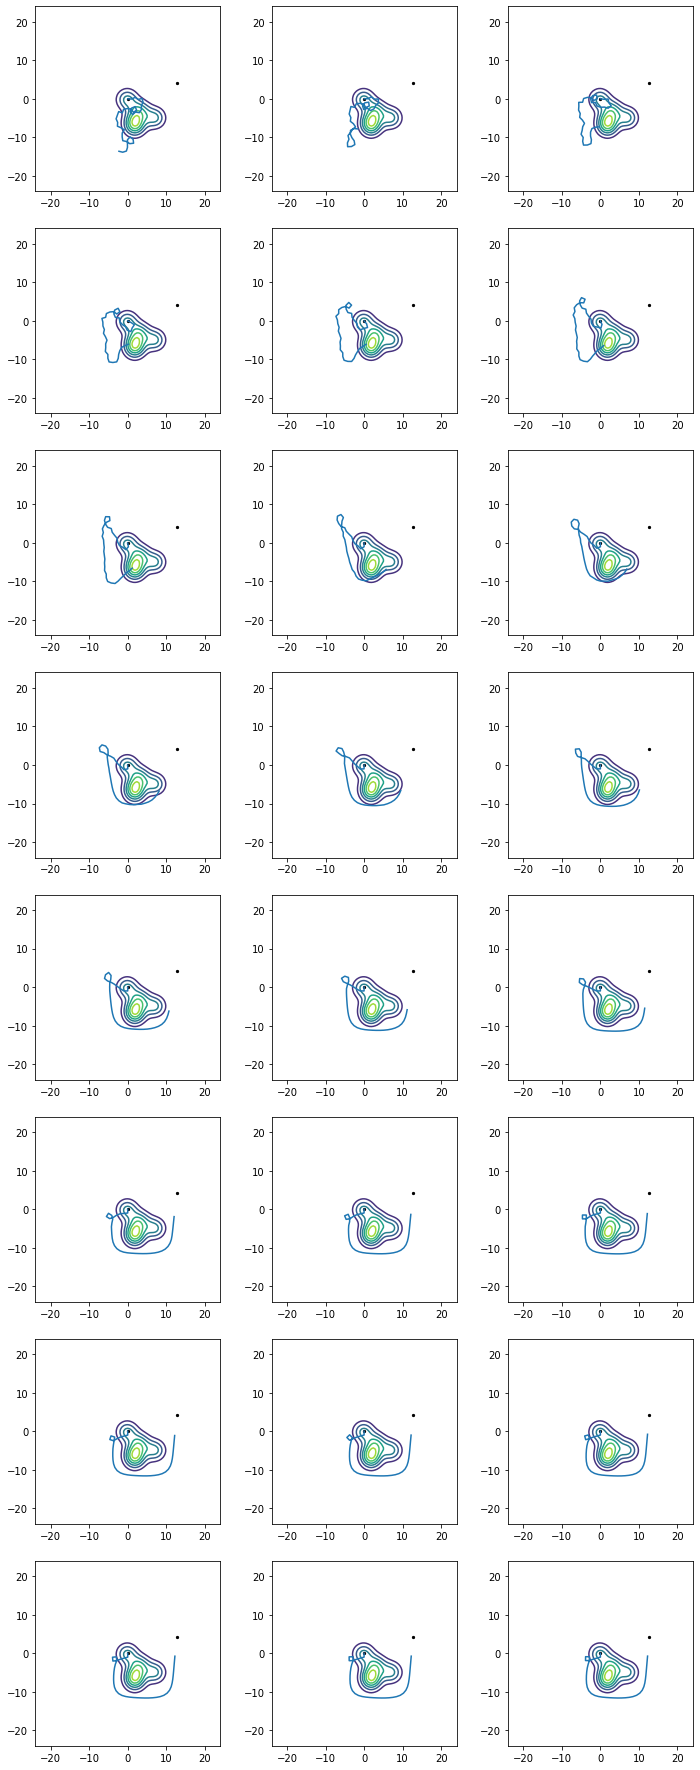

In [15]:
# trying to get to a target by "steering" (choosing an angle change)
# given constant step length 1, and also imposing a smoothness constraint

# L2 smoothness penalty here

# add a cost to-go-on the landscape; a bump function to be avoided

T=40

maxTurn=np.pi/2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

steering_inputs = torch.randn(1,T, requires_grad=True, device=device)

targetRad = T/3
targetDirection = ((torch.rand(1)-.5)*np.pi).to(device)
target = (torch.cat([torch.cos(targetDirection),torch.sin(targetDirection)],0)*targetRad).to(device)

N_bumps = 5
bumpRad = .5*(targetRad + .5*targetRad*torch.randn(1,N_bumps)).to(device)
bumpStd = targetRad/2
bumpDirection = ((torch.rand(1,N_bumps)-.5)*np.pi).to(device)
bumpPos = (torch.cat([torch.cos(bumpDirection),torch.sin(bumpDirection)],0)*bumpRad).to(device)

optAdam  = torch.optim.Adam([steering_inputs], lr=3e-4)

r,c = 8,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

M = 1000
for i in range(r*c*M):
    steering_inputs_clamped = torch.clamp(steering_inputs,-maxTurn,maxTurn)
    headings = torch.cumsum(steering_inputs_clamped,1)

    steps = torch.cat([torch.cos(headings),torch.sin(headings)],0)
    steps_with_x0 = torch.cat([torch.zeros(2,1).to(device),steps],1)

    pos = torch.cumsum(steps_with_x0,1)

    loss = (torch.sum((pos[:,-1] - target)**2)
        + torch.sum(steering_inputs**2)
        + 5 * closeToBumpLoss(pos, bumpPos, bumpStd)
    )

    optAdam.zero_grad()
    loss.backward()
    optAdam.step()

    if i%M == 0:
        plotHeadingStepsWithBump(
            pos.detach().cpu().numpy(),
            target.detach().cpu().numpy(),
            bumpPos.detach().cpu().numpy(),
            bumpStd,
            radius=.6*T,
            ax = axs[i//M]
        )
        # plotHeadingSteps(pos.detach().numpy(), target.detach().numpy(), ax = axs[i//M], radius=T)
